# Analyze ensemble parameter simulation output
Analyzing updated batch of ensemble simulations since 'sim_opt100.ipynb'. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt (previous outputs now moved to archive)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import datetime
import seaborn as sns
import pingouin as pg

# my functions
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import YlGn_9
from funcs import fold, get_filelist, read_sims
from funcs_fig import maps, bars

## 1. Data prep and setup

#### 1.1 Read in maizsim outputs
- get_filelist: for the given path, retrieve list of all files within the directory tree, including those in subdirectories
- read_sims: read in last line of maizsim simulation output, organize and form into pd.DataFrame
- outputs: **df_sims**

In [2]:
#filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/1961/')
#files = filelist[:10]
files = filelist[:]
df_sims, df_issues = read_sims(files)
df_sims.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961     0  722060  04/07/1961  22378   23   1.92          0        0   
1  1961     0  722070  07/25/1961  22487   15  23.00         23       19   
2  1961     0  722080  07/29/1961  22491    1  23.00         23       18   
3  1961     0  722140  07/25/1961  22487   17  24.00         24       20   
4  1961     0  722170  07/26/1961  22488   21  24.00         24       20   

       LA  ... dm_ear dm_totleaf dm_dropleaf df_stem df_root roil_rt  \
0    9.27  ...   0.00       0.22        0.00    0.03   0.110   0.110   
1  306.79  ...  69.68      13.87        9.38   21.39  58.106  58.147   
2  308.13  ...  73.07      12.50        7.39   28.05  71.361  71.354   
3  308.71  ...  54.69      17.77       12.03   36.51  59.397  59.380   
4  312.79  ...  40.28      10.32        7.04   19.02  48.128  48.137   

  mx_rootdept available_water soluble_c          note  
0         0.0           0.000      0.00  "Germinated"  
1         0.0           0.000      0.08     "Matured"  
2         0.0           0.000      0.26     "Matured"  
3         0.0           0.000      0.08     "Matured"  
4         0.0           0.000      0.12     "Matured"  

[5 rows x 53 columns]

#### 1.2 Read in site info
- Site info: **df_sites**
- Filtered site-years: **siteyears**

In [3]:
# read in site infof
df_sites_all = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                           index_col=0, dtype={'site': str})

# filter based on planting area & irrigation
df_sites = df_sites_all[(df_sites_all.area > 1000) & (df_sites_all.perct_irri < 50)]
df_sites.head()

site  class                         station state  tzone     lat     lon  \
5  722060      1          JACKSONVILLE INTL ARPT    FL     -5  30.500 -81.700   
6  722070      1                SAVANNAH INTL AP    GA     -5  32.117 -81.200   
7  722080      1            CHARLESTON INTL ARPT    SC     -5  32.900 -80.033   
8  722110      1          TAMPA INTERNATIONAL AP    FL     -5  27.967 -82.533   
9  722140      1  TALLAHASSEE REGIONAL AP [ISIS]    FL     -5  30.400 -84.350   

   years     area  perct_irri  
5     27   4978.0   10.089223  
6     22   8108.6    6.585904  
7     25  41559.4    5.152189  
8      8  50807.8   31.561666  
9     19  24496.7   13.348148

In [4]:
# fetching list of site-years
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', 
                            usecols=[1,2], dtype='str') 
siteyears = siteyear_ctr2[siteyear_ctr2.site.isin(df_sites.site)] 

#### 1.3 Read in weather info

In [5]:
# still working on a script to generate this csv file
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', dtype={'site': 'str'}, index_col=0)
df_wea.reset_index(inplace=True, drop=True)
df_wea.head()

site  year       temp         rh  precip      solrad       vpd
0  722060  1961  23.875626  73.319667   711.7  224.052621  0.804103
1  722060  1962  24.837383  71.376170   844.3  231.331182  0.915040
2  722060  1964  24.184194  75.293234  1050.7  217.245110  0.758866
3  722060  1965  24.555986  73.515469   937.3  223.575509  0.832212
4  722060  1966  23.630849  76.711442  1158.9  213.357394  0.691391

#### 1.4 Read in parameter info and standardize
- Parameter info: **df_params**
- Standardized parameter info: **df_params_fold**

In [6]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])

df_params['cvar'] = list(df_params.index)
df_params_fold['cvar'] = list(df_params.index)
df_params_fold.head()

juv_leaves  stayGreen  rmax_ltir  phyllo   LM_min   Vcmax     Vpmax  \
0         0.8      0.288       0.74   0.655  0.46925  0.8645  0.542833   
1         0.1      0.826       0.05   0.990  0.24625  0.3550  0.463500   
2         0.6      0.702       0.50   0.520  0.03100  0.3325  0.359333   
3         0.9      0.334       0.18   0.620  0.44250  0.4780  0.161167   
4         0.5      0.264       0.32   0.565  0.87700  0.2220  0.687833   

         g1  ref_potential  cvar  
0  0.984444       0.206667     0  
1  0.041111       0.390000     1  
2  0.320000       0.456667     2  
3  0.428889       0.123333     3  
4  0.590000       0.200000     4

#### 1.4 Merging simulation outputs, weather, site, & parameter info
- all data stored: **df_all**

In [8]:
df_sims_params = pd.merge(df_sims, df_params, on='cvar')
df_sims_params_sites = pd.merge(df_sims_params, df_sites, on='site')
df_all = pd.merge(df_sims_params_sites, df_wea, on=['site','year'])
df_all.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961     0  722060  04/07/1961  22378   23   1.92          0        0   
1  1961     1  722060  08/15/1961  22508   13  18.00         18       15   
2  1961     2  722060  07/31/1961  22493   15  21.00         21       18   
3  1961     3  722060  08/03/1961  22496    6  25.00         25       20   
4  1961     4  722060  07/31/1961  22493    8  21.00         21       17   

       LA  ...   lat   lon years    area perct_irri       temp         rh  \
0    9.27  ...  30.5 -81.7    27  4978.0  10.089223  23.875626  73.319667   
1  160.24  ...  30.5 -81.7    27  4978.0  10.089223  23.875626  73.319667   
2  188.85  ...  30.5 -81.7    27  4978.0  10.089223  23.875626  73.319667   
3  354.63  ...  30.5 -81.7    27  4978.0  10.089223  23.875626  73.319667   
4  329.70  ...  30.5 -81.7    27  4978.0  10.089223  23.875626  73.319667   

  precip      solrad       vpd  
0  711.7  224.052621  0.804103  
1  711.7  224.052621  0.804103  
2  711.7  224.052621  0.804103  
3  711.7  224.052621  0.804103  
4  711.7  224.052621  0.804103  

[5 rows x 76 columns]

#### 1.5 Group simulation outputs by cultivars or by sites
- outputs: **df_sims_sitemean**, **df_sims_cvarmean**

In [7]:
df_sims_sitemean = df_all.groupby(['site']).mean()
df_sims_cvarmean = df_all.groupby(['cvar']).mean()

## 2. Summary visualization

#### Average yield outcome from all cultivars

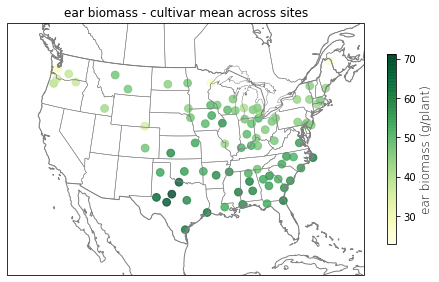

In [9]:
sites = df_sites[df_sites.site.isin(df_sims_sitemean.index)]
maps(sites, df_sims_sitemean, cbar_lab='ear biomass (g/plant)',
     title='ear biomass - cultivar mean across sites')

#### Ear biomass across all sites
Same info as map above, but in bar graph form

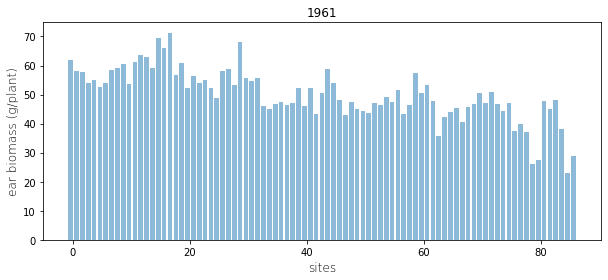

In [10]:
data = df_sims_sitemean.dm_ear
bars(data, xlab='sites', ylab='ear biomass (g/plant)', title='1961')

#### Ear biomass across all cultivars
Details yield for each cultivar

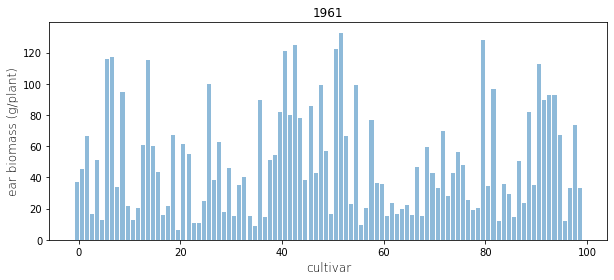

In [11]:
data = df_sims_cvarmean.dm_ear
bars(data, xlab='cultivar', ylab='ear biomass (g/plant)', title='1961')

#### Highest yielding cultivar for each site

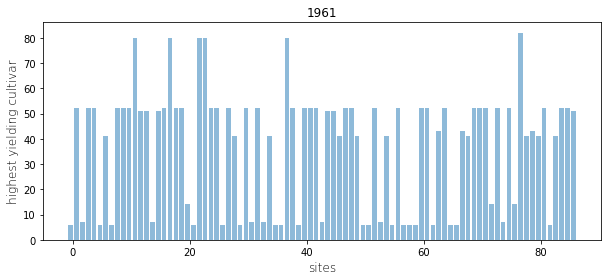

In [24]:
ears = []
cvars_high = []
sites = list(set(df_all.site))

for i in sites:
    df_site = df_all[df_all.site == i]
    ear = df_all.dm_ear.max()
    cvar = float(df_site[df_site.dm_ear == df_site.dm_ear.max()].cvar)
    ears.append(ear)
    cvars_high.append(cvar)

bars(cvars_high, xlab='sites', ylab='highest yielding cultivar', title='1961')

In [23]:
# parameter values for high-yielding cultivars
hyield_vars = list(set(cvars_high))
df_params.iloc[hyield_vars,:]

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax  Vpmax    g1  \
6           20       4.86       1.35    3.52  116.40  61.87  85.07  3.16   
7           17       6.16       1.02    2.74  119.72  66.05  72.75  6.99   
41          17       3.59       1.28    3.09  103.13  64.23  65.47  4.87   
43          19       3.27       1.32    2.19  112.62  74.30  77.34  7.44   
14          18       6.77       1.38    3.78   85.61  64.07  75.47  6.25   
80          21       5.64       1.27    2.87  115.80  60.05  68.47  9.54   
82          23       5.80       1.38    2.17  119.26  60.67  95.79  6.70   
51          21       6.12       1.26    3.76  115.51  74.76  80.60  7.80   
52          21       7.71       1.41    3.70  110.89  71.05  63.37  7.96   

    ref_potential  cvar  
6           -2.44     6  
7           -1.24     7  
41          -1.23    41  
43          -1.88    43  
14          -1.92    14  
80          -2.31    80  
82          -3.69    82  
51          -1.80    51  
52          -1.30    52

#### Lowest yielding cultivar for each site

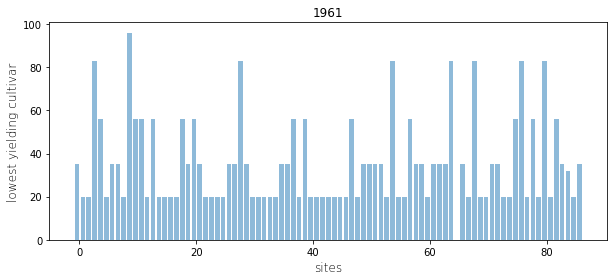

In [25]:
ears = []
cvars_low = []
sites = list(set(df_all.site))

for i in sites:
    df_site = df_all[df_all.site == i]
    ear = df_all.dm_ear.min()
    cvar = float(df_site[df_site.dm_ear == df_site.dm_ear.min()].cvar)
    ears.append(ear)
    cvars_low.append(cvar)

bars(cvars_low, xlab='sites', ylab='lowest yielding cultivar', title='1961')

In [21]:
# parameter values for low-yielding cultivars
lyield_vars = list(set(cvars_low))
df_params.iloc[lyield_vars,:]

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
96          22       6.28       0.57    3.87  103.52  79.57   84.49  1.70   
0           23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
32          16       3.61       0.52    3.37   86.15  78.39   62.64  5.65   
35          24       6.59       0.61    3.92  112.07  65.13  105.05  4.22   
83          22       3.22       0.54    2.21   93.37  75.28   79.41  3.74   
20          23       3.10       0.64    2.28   88.68  73.99  118.81  9.28   
56          20       7.99       0.56    2.69  105.28  60.92   67.01  9.26   

    ref_potential  cvar  
96          -2.98    96  
0           -3.38     0  
32          -2.18    32  
35          -2.33    35  
83          -1.47    83  
20          -3.75    20  
56          -3.92    56

## 3. Stats & Analyses

Text(0.09, 0.5, 'ear biomass (g/plant)')

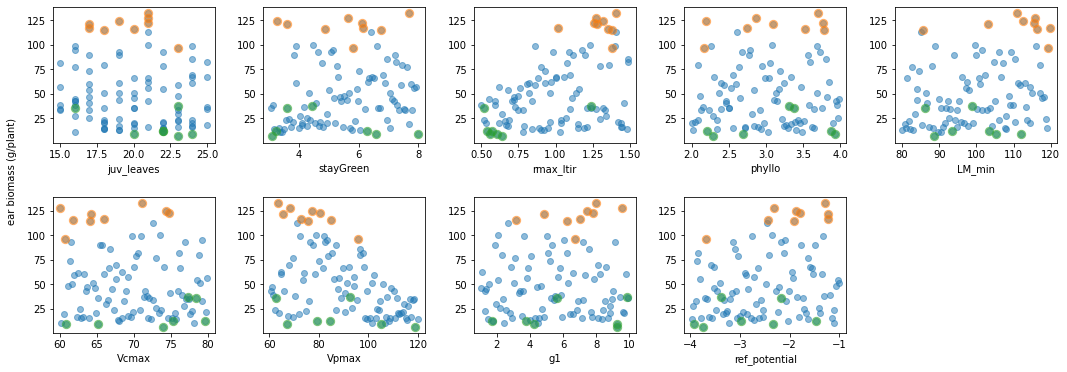

In [100]:
fig = plt.figure(figsize=(18,6))

for i in np.arange(1,10): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set_xlabel(df_params.columns[i-1])
    
    ax.scatter(df_params.iloc[hyield_vars,i-1], df_sims_cvarmean.iloc[hyield_vars].dm_ear, s=70, alpha=0.5)
    ax.scatter(df_params.iloc[lyield_vars,i-1], df_sims_cvarmean.iloc[lyield_vars].dm_ear, s=70, alpha=0.5)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig.text(0.09, 0.5, 'ear biomass (g/plant)', va='center', rotation='vertical')

#### 3.1 Partial correlation coefficient

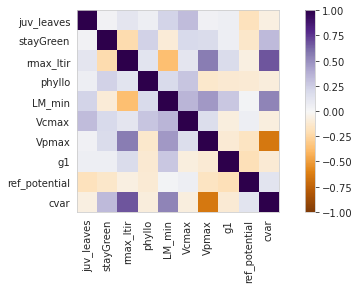

In [106]:
params = list(df_params.columns) # remove 'cvar' column

with sns.axes_style('whitegrid'): # adding this line just makes the figure look a bit nicer
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(0,10))
    ax.set_xticklabels(params, rotation=90)
    ax.set_yticks(np.arange(0,10))
    ax.set_yticklabels(params, rotation=0)

    ax.grid(False)
    plt.colorbar(im)
    fig.subplots_adjust(left=-0.5, bottom=0.25, right=0.95, top=0.95)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

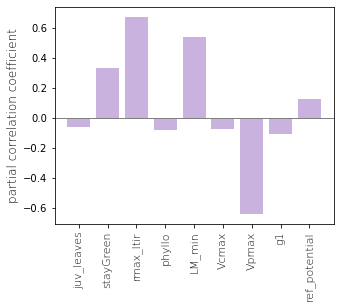

In [88]:
# setting up parameter values and ear biomass
df_stats = pd.concat([df_params.iloc[:,:-1], # remove 'cvar' column
                      df_sims_cvarmean.dm_ear], # including mean ear biomass for each cultivar
                     axis=1) 

# calculate partial correlation coefficient
from partial_corr import partial_corr
output = partial_corr(df_stats)
params = list(df_params.columns[:-1]) # remove 'cvar' column
corrs = output[-1][:-1] # select final row in correlation matrix - correlation with ear biomass,
                        # and remove final correlation coefficient,
                        # which is the correlation coefficient with ear biomass itself = 1

# figure 
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params, corrs, alpha=0.5, color='tab:purple')
ax.set_ylabel('partial correlation coefficient', fontsize=12, weight='light')
ax.axhline(0, color='grey', lw=1)
plt.xticks(rotation=90, fontsize=11, weight='light')

In [110]:
# how to get stat values for PCC
df_stats.partial_corr(x='dm_ear', y='rmax_ltir',
                      covar=['juv_leaves', 'stayGreen', 'phyllo', 'LM_min', 'Vcmax', 'Vpmax', 'g1', 'ref_potential'])

n         r         CI95%       r2    adj_r2         p-val  \
pearson  100  0.674151  [0.55, 0.77]  0.45448  0.443232  1.496698e-14   

              BF10  power  
pearson  5.482e+11    1.0

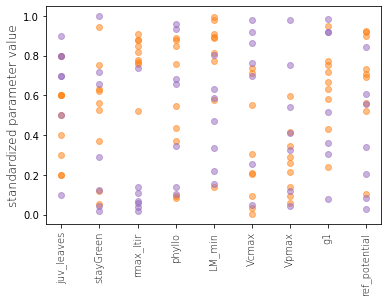

In [98]:
# setting up
params = list(df_params.columns[:-1])

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

# plotting
for counter,param in enumerate(params):
    plt.scatter([param]*len(hyield_vars), fold(list(df_params.iloc[hyield_vars,:][param]), 
                                  param_range[param][0], param_range[param][1]), 
                alpha=0.5, color='tab:orange')
    plt.scatter([param]*len(lyield_vars), fold(list(df_params.iloc[lyield_vars,:][param]), 
                              param_range[param][0], param_range[param][1]), 
            alpha=0.5, color='tab:purple')
    plt.xticks(rotation=90, weight='light')
    plt.ylabel('standardized parameter value', size=12, weight='light')

#### Final phenological stages

Apparently there are still sites that are having trouble reaching later developmental stages <br/>
-- mostly in Northern locations

In [ ]:
def maps_multi():
    for i in np.arange(1,6):
        ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                             central_latitude=39.5, central_longitude=-98.35))
        ax.set_extent([-123, -72, 19, 53])
        test_sites = set(df_sims[df_sims.note == stages[i-1]].site)
        test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]
        ax.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
                    s=60, c='tab:purple', alpha=0.7)
        ax.add_feature(cfeature.BORDERS, edgecolor='grey')
        ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
        ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
        ax.set_title('reached: ' + stages[i-1])
    fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.3)

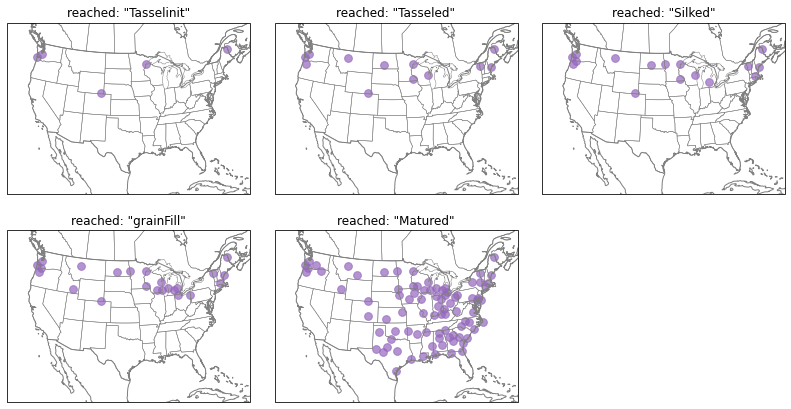

In [16]:
fig = plt.figure(figsize=(12,7))
stages = ['"Tasselinit"', '"Tasseled"', '"Silked"', '"grainFill"', '"Matured"']

for i in np.arange(1,6):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    test_sites = set(df_sims[df_sims.note == stages[i-1]].site)
    test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]
    ax.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
                s=60, c='tab:purple', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('reached: ' + stages[i-1])
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.3)

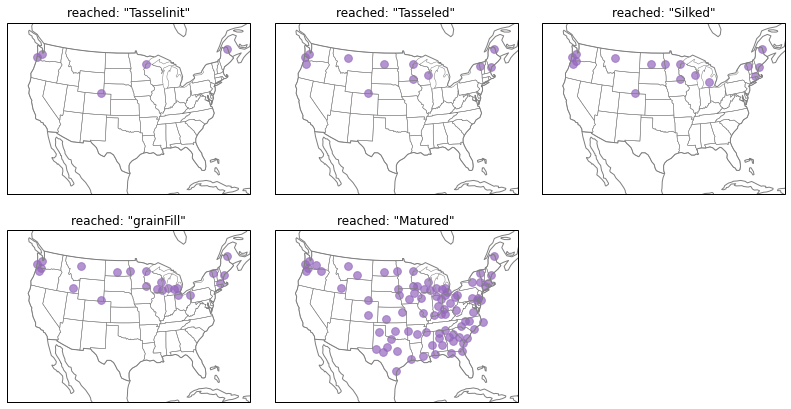

In [14]:
fig = plt.figure(figsize=(12,7))
stages = ['"Tasselinit"', '"Tasseled"', '"Silked"', '"grainFill"', '"Matured"']

for i in np.arange(1,6):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    test_sites = set(df_sims[df_sims.note == stages[i-1]].site)
    test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]
    ax.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
                s=60, c='tab:purple', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('reached: ' + stages[i-1])
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.3)

#### Full visualization of sim outputs from year 1961

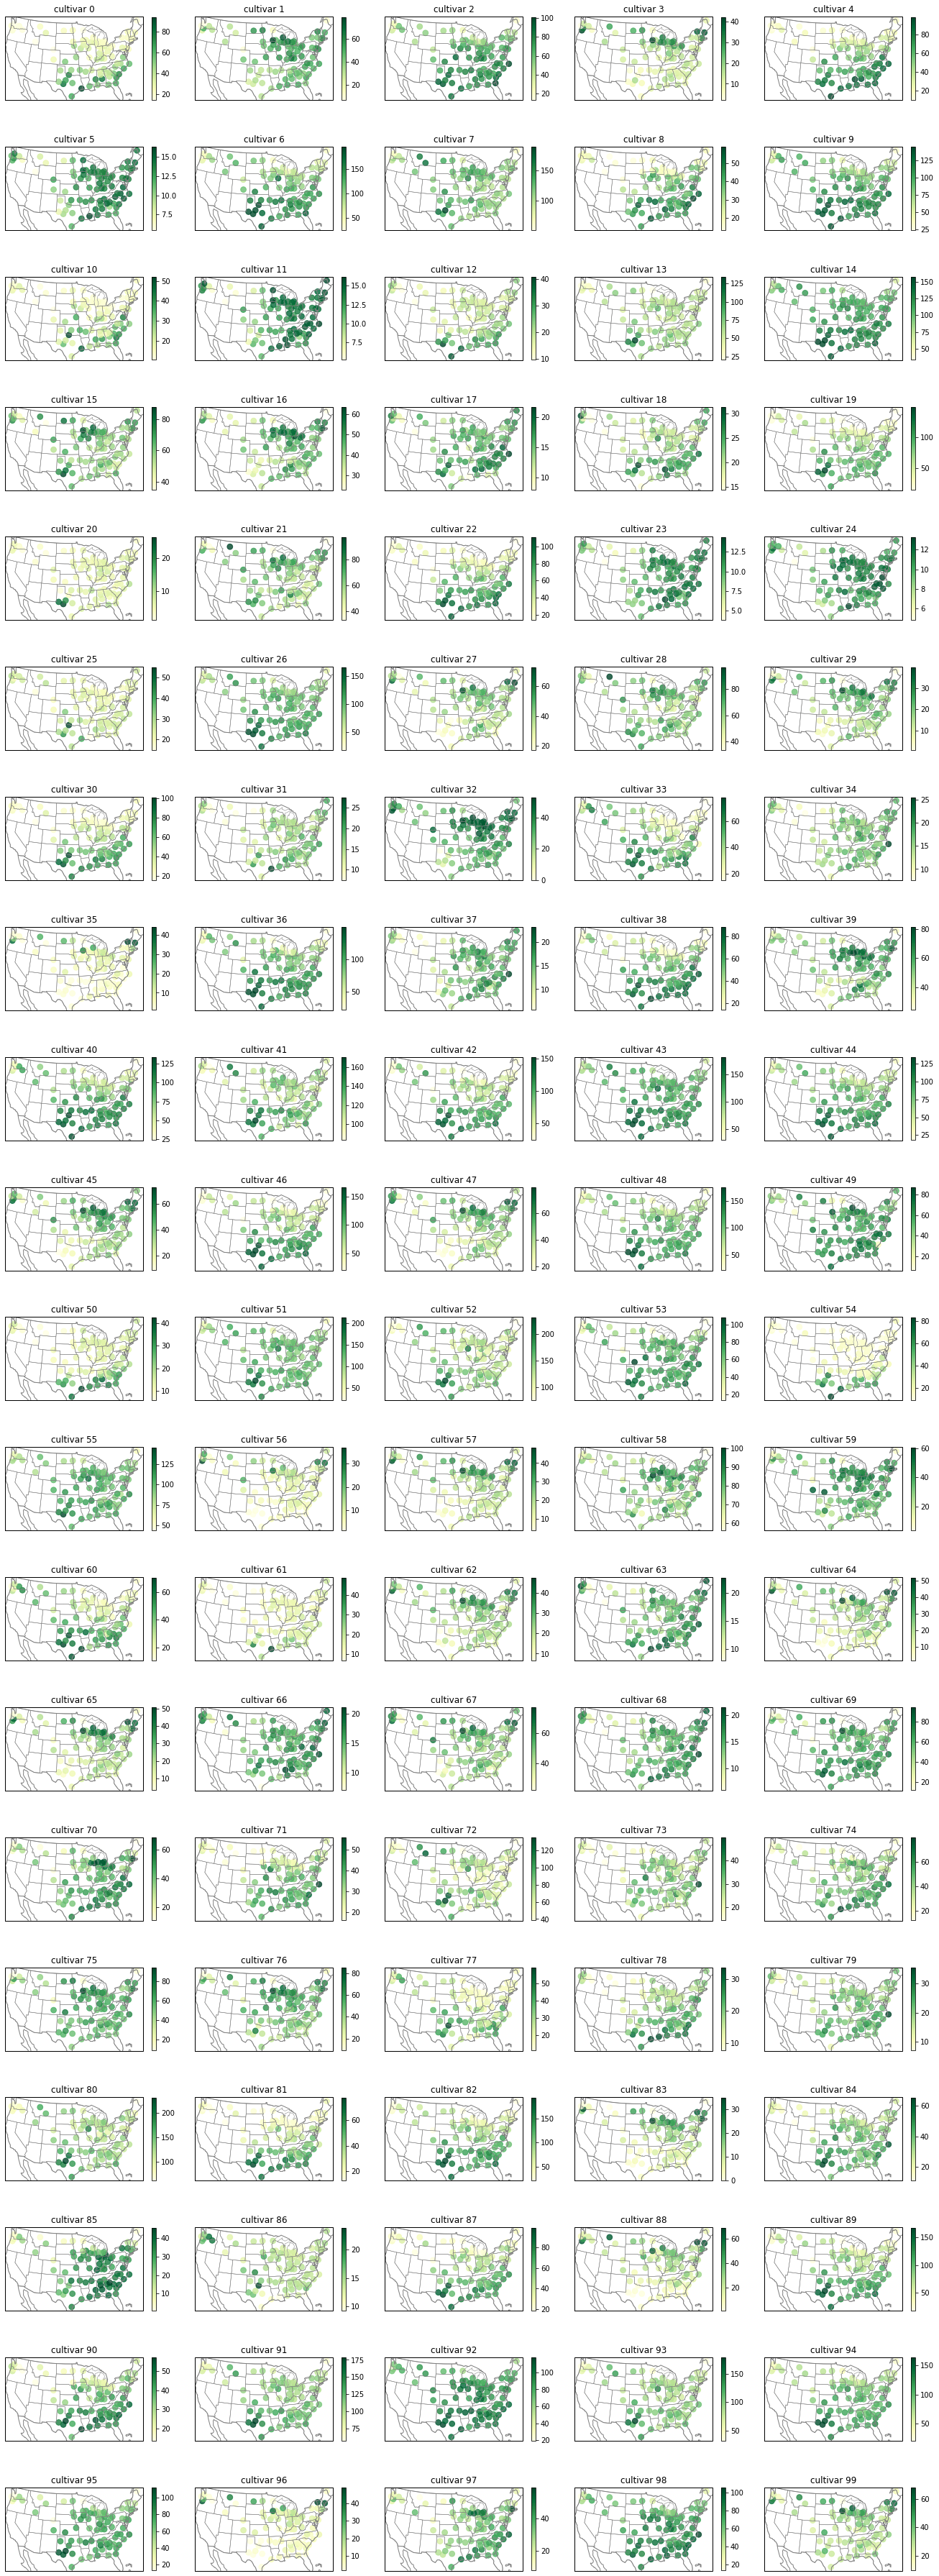

In [35]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]

sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    mp = ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
#                   s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, vmin=0, vmax=200, alpha=0.8)
                    s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)

    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))
    cbar = fig.colorbar(mp, ax=ax, shrink=0.7)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=0.1)

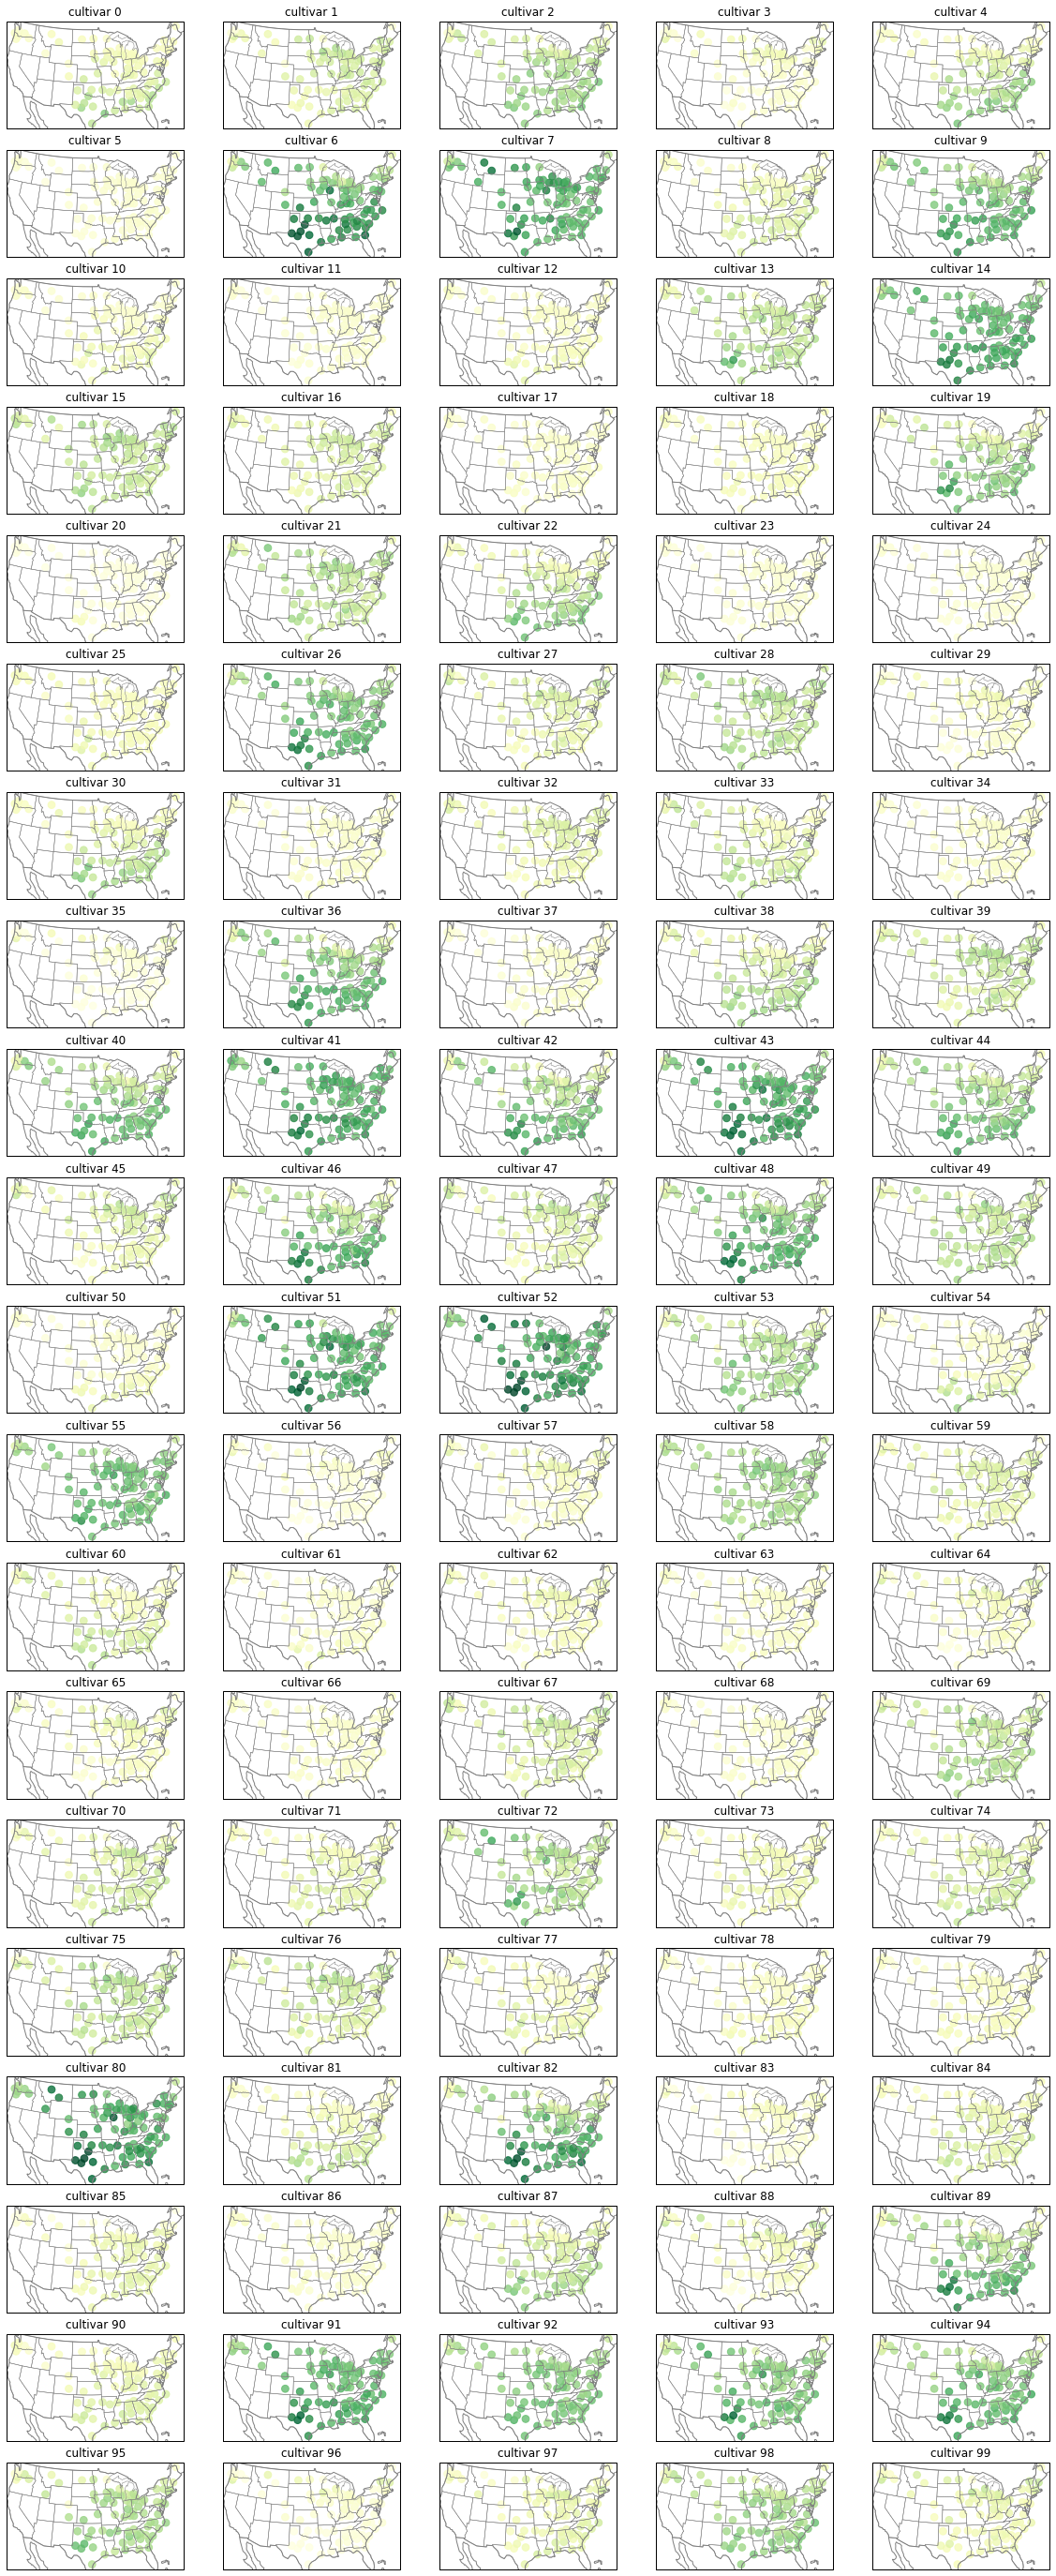

In [165]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]

sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
               s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, vmin=0, vmax=200, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/yieldmaps_61.png', format='png', dpi=800, transparent=True)

#### *Note when converting from dm_ear to yield:
1. Planting density 
2. Shelling percentage (grain weight/ear weight)
    - scaler that converts ear mass to actual grain yield
    - 0.86 is the scale value used in previous paper but need to find citation to back it
    - Looking around seems like 0.8 is a common value people use when corn is harvested at ~20-25% grain moisture
    - Haven't really found a good citation yet, but here are a few links to start with: 
        - Tandzi and Mutengwa, 2020, Agronomy
        - Masuka et al., 2017, Crop Science (80% shelling percentage and 12.5% grain moisture)
        - Horrocks and Zuber, 1970

### Including weather information

In [14]:
# reading in weather data
#df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
#df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
#df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
#df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv', index_col= 0)

# interpolating weather data 
#df_temp = df_temp.interpolate()
#df_rh = df_rh.interpolate()
#df_precip = df_precip.interpolate()
#df_solrad = df_solrad.interpolate()

In [15]:
# filtering sites based on planting area & irrigation
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', 
                            usecols=[1,2], dtype='str') 
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', 
                         index_col=0, dtype={'site': str})
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]
siteyears = siteyear_ctr2[siteyear_ctr2.site.isin(df_filtered.site)] # df_filtered accounts for irrigation & planting area
                                                                     # and has AK, GU, HI, & PR removed already

In [18]:
# converting the dataframe-style weather data into a single long-form list
# - only selecting weather data for filtered siteyears
# - plotting data for growing season between 4/1 - 10/31
temp_all = [np.nan]*siteyears.shape[0]
rh_all = [np.nan]*siteyears.shape[0]
precip_all = [np.nan]*siteyears.shape[0]
solrad_all = [np.nan]*siteyears.shape[0]

for i in np.arange(siteyears.shape[0]):
    # growing season temp mean for each site-year
    temp = df_temp.loc[siteyears.iloc[i,1] + '-04-01' : 
                       siteyears.iloc[i,1] +'-10-31', 
                       siteyears.iloc[i,0]].mean()
    # growing season RH mean for each site-year
    rh = df_rh.loc[siteyears.iloc[i,1] + '-04-01' : 
                   siteyears.iloc[i,1] +'-10-31', 
                   siteyears.iloc[i,0]].mean()
    # growing season precip sum for each site-year
    precip = df_precip.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].sum()

    # 
    solrad = df_solrad.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].mean()
    
    
    temp_all[i] = temp
    rh_all[i] = rh
    precip_all[i] = precip
    solrad_all[i] = solrad
    
# calculating VPD based on temperature & RH
vpd_all = []
for i in np.arange(len(temp_all)):
    vpd_all.append(CC_VPD(temp_all[i], rh_all[i]/100))
    
# storing output in dataframe
df_siteyears_weamean = siteyears.copy()
df_siteyears_weamean['temp'] = list(temp_all)
df_siteyears_weamean['rh'] = list(rh_all)
df_siteyears_weamean['precip'] = list(precip_all)
df_siteyears_weamean['solrad'] = list(solrad_all)
df_siteyears_weamean['vpd'] = list(vpd_all)
df_siteyears_weamean = pd.merge(df_siteyears_weamean, df_filtered, on='site')

In [34]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params['cvar'] = df_params.index
df_sims_m = pd.merge(df_sims, df_params, on='cvar')
df_sims_merged = pd.merge(df_sims_m, df_siteyears_weamean, on=['site','year'])
df_sims_merged.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961   0.0  722060  04/07/1961  22378   23   1.92          0        0   
1  1961   1.0  722060  08/15/1961  22508   13  18.00         18       15   
2  1961   2.0  722060  07/31/1961  22493   15  21.00         21       18   
3  1961   3.0  722060  08/03/1961  22496    6  25.00         25       20   
4  1961   4.0  722060  07/31/1961  22493    8  21.00         21       17   

       LA  ...       vpd class                 station state tzone   lat  \
0    9.27  ...  0.804103     1  JACKSONVILLE INTL ARPT    FL    -5  30.5   
1  160.24  ...  0.804103     1  JACKSONVILLE INTL ARPT    FL    -5  30.5   
2  188.85  ...  0.804103     1  JACKSONVILLE INTL ARPT    FL    -5  30.5   
3  354.63  ...  0.804103     1  JACKSONVILLE INTL ARPT    FL    -5  30.5   
4  329.70  ...  0.804103     1  JACKSONVILLE INTL ARPT    FL    -5  30.5   

    lon years    area perct_irri  
0 -81.7    27  4978.0  10.089223  
1 -81.7    27  4978.0  10.089223  
2 -81.7    27  4978.0  10.089223  
3 -81.7    27  4978.0  10.089223  
4 -81.7    27  4978.0  10.089223  

[5 rows x 76 columns]

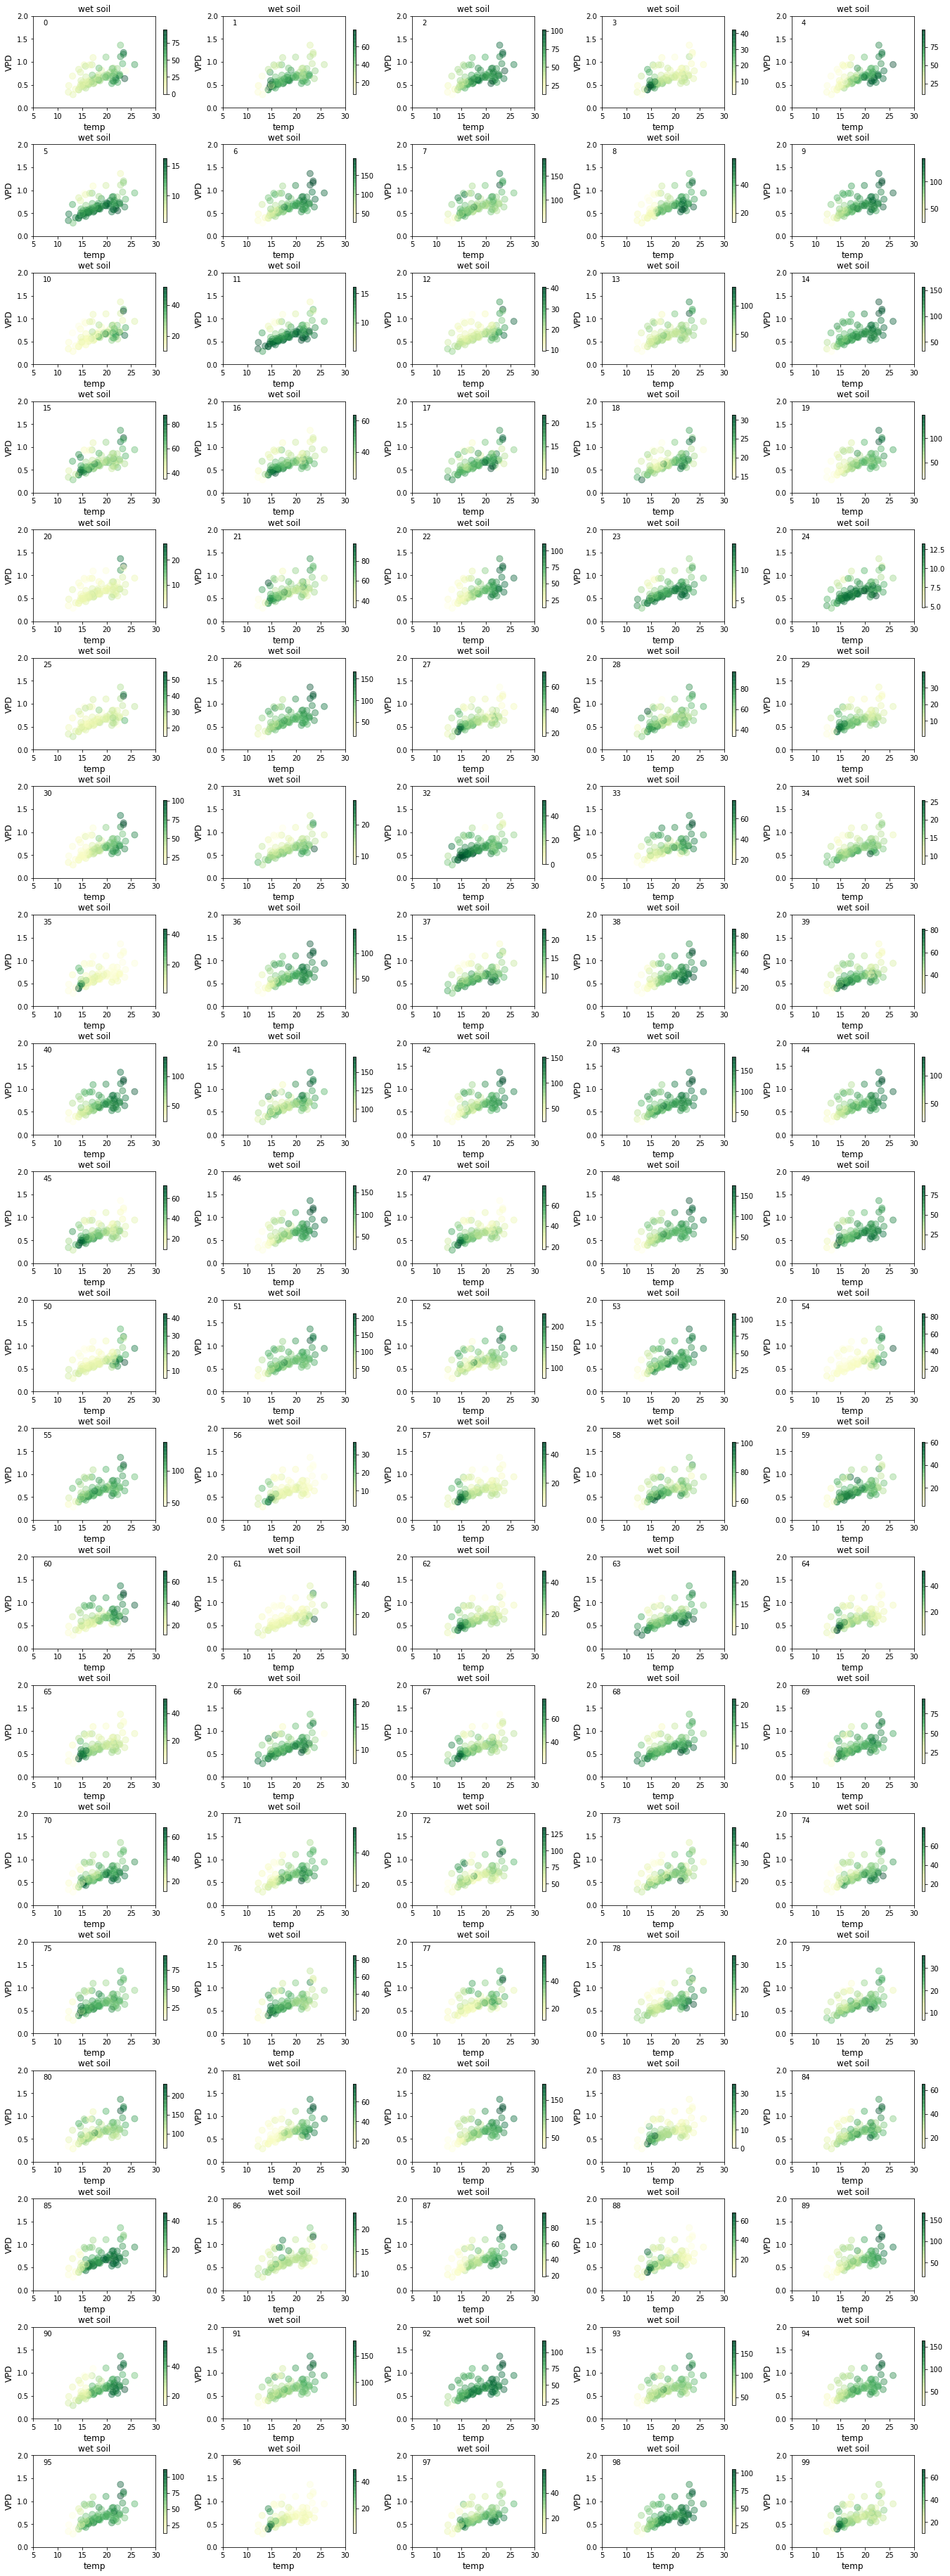

In [37]:
fig, axs = plt.subplots(20, 5, figsize=(20, 50))
cvars = np.arange(100)

for ax, cvar in zip(axs.flatten(), cvars):
    df_sims_cv = df_sims_merged[df_sims_merged.cvar==cvar]
    sc = ax.scatter(df_sims_cv.temp, df_sims_cv.vpd, 
                    c=df_sims_cv.dm_ear, cmap=YlGn_9.mpl_colormap, 
                    alpha=0.4, s=80)
    ax.set_xlabel('temp', size=12)
    ax.set_xlim(5,30)
    ax.set_ylim(0,2)
    ax.set_ylabel('VPD', size=12)
    ax.text(7,1.8, cvar)
    ax.set_title('wet soil')
#    ax.set(title='cultivar ' + str(cvar))
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.24, hspace=0.4)

In [370]:
df_year = df_siteyears_weamean[df_siteyears_weamean.year=='1961']
df_year.head()

site  year       temp         rh  precip      solrad       vpd  class  \
0    722060  1961  23.875626  73.319667   711.7  224.052621  0.804103      1   
27   722070  1961  22.527191  74.713304   881.8  234.060642  0.701216      1   
49   722080  1961  21.895951  77.313629   899.4  232.128717  0.604899      1   
82   722140  1961  22.738077  75.005814   735.9  229.369523  0.702224      1   
101  722170  1961  22.185094  68.543369   605.2  230.181534  0.853975      1   

                            station state  tzone     lat     lon  years  \
0            JACKSONVILLE INTL ARPT    FL     -5  30.500 -81.700     27   
27                 SAVANNAH INTL AP    GA     -5  32.117 -81.200     22   
49             CHARLESTON INTL ARPT    SC     -5  32.900 -80.033     25   
82   TALLAHASSEE REGIONAL AP [ISIS]    FL     -5  30.400 -84.350     19   
101     MACON MIDDLE GA REGIONAL AP    GA     -5  32.683 -83.650     22   

        area  perct_irri  
0     4978.0   10.089223  
27    8108.6    6.585904  
49   41559.4    5.152189  
82   24496.7   13.348148  
101  19022.8   18.039572

In [498]:
temp_threshold = 18
vpd_threshold = 0.7

df_hthv = df_year[(df_year.temp>temp_threshold) & (df_year.vpd>vpd_threshold)]
df_htlv = df_year[(df_year.temp>temp_threshold) & (df_year.vpd<vpd_threshold)]
df_lthv = df_year[(df_year.temp<temp_threshold) & (df_year.vpd>vpd_threshold)]
df_ltlv = df_year[(df_year.temp<temp_threshold) & (df_year.vpd<vpd_threshold)]

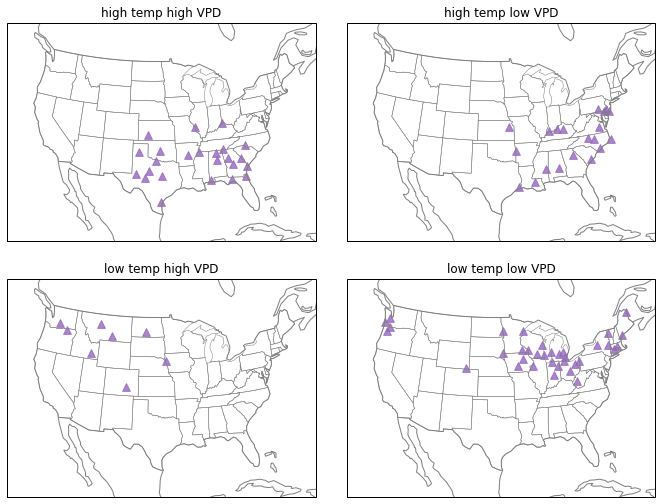

In [529]:
fig = plt.figure(figsize=(10,8))

dframes = [df_hthv, df_htlv, df_lthv, df_ltlv]
titles = ['high temp high VPD', 'high temp low VPD',
          'low temp high VPD', 'low temp low VPD']

for i in np.arange(4):
    ax = fig.add_subplot(2,2,i+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])

    mp = ax.scatter(dframes[i].lon, dframes[i].lat, transform=ccrs.PlateCarree(), 
                    s=60, marker='^', c='tab:purple', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(titles[i])
#    cbar = fig.colorbar(mp, shrink=0.4)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.2)

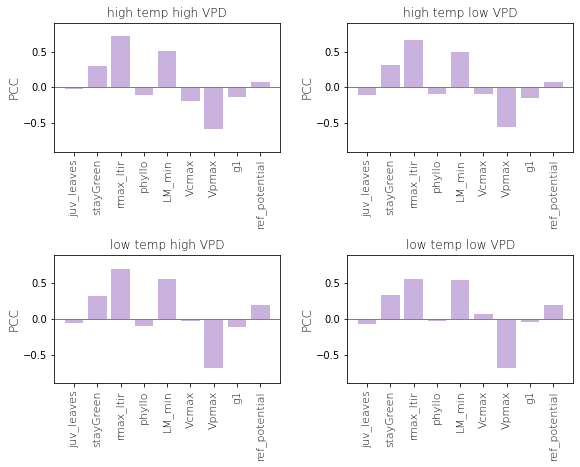

In [506]:
# setting up parameter values and ear biomass
dframes = [df_hthv, df_htlv, df_lthv, df_ltlv]
titles = ['high temp high VPD', 'high temp low VPD', 
          'low temp high VPD', 'low temp low VPD']

fig = plt.figure(figsize=(8,5))

for i in np.arange(4):
    df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
    df_params = df_params.drop(['rmax_ltar'], axis=1)
    df_sims_sub = pd.Series(df_sims[df_sims.site.isin(list(dframes[i].site))].groupby('cvar').mean().dm_ear)
    df_params = pd.concat([df_params, df_sims_sub], axis=1)

    # calculate partial correlation coefficient
    from partial_corr import partial_corr
    output = partial_corr(df_params)

    # plotting
    ax = fig.add_subplot(2,2,i+1)
    params = list(df_params.columns[:-1])
    corrs = output[-1][:-1]
    ax.bar(params, corrs, alpha=0.5, color='tab:purple')
    ax.set_ylim([-0.9, 0.9])
    ax.set_ylabel('PCC', fontsize=12, weight='light')
    ax.axhline(0, color='grey', lw=1)
    plt.xticks(rotation=90, fontsize=11, weight='light')    
    plt.title(titles[i], weight='light')

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.3, hspace=0.8)

In [537]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_sims_sub = pd.Series(df_sims[df_sims.site.isin(list(df_ltlv.site))].groupby('cvar').mean().dm_ear)
df_params = pd.concat([df_params, df_sims_sub], axis=1)

df_params.partial_corr(x='dm_ear', y= 'ref_potential',
                       covar=['rmax_ltir', 'g1', 'stayGreen','phyllo', 'LM_min', 'Vcmax', 'Vpmax', 'juv_leaves'])

n         r        CI95%        r2    adj_r2    p-val   BF10  \
pearson  100  0.197674  [0.0, 0.38]  0.039075  0.019262  0.04868  0.848   

           power  
pearson  0.50855

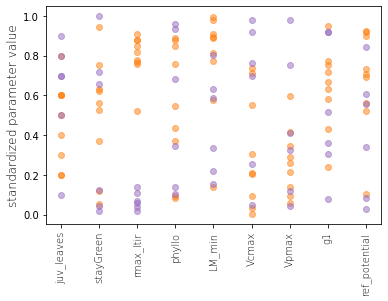

In [804]:
# setting up
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
params = list(df_params.columns)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

# plotting
for counter,param in enumerate(params):
    plt.scatter([param]*9, fold(list(df_params.iloc[hyield_vars,:][param]), 
                                  param_range[param][0], param_range[param][1]), 
                alpha=0.5, color='tab:orange')
    plt.scatter([param]*6, fold(list(df_params.iloc[lyield_vars,:][param]), 
                              param_range[param][0], param_range[param][1]), 
            alpha=0.5, color='tab:purple')
    plt.xticks(rotation=90, weight='light')
    plt.ylabel('standardized parameter value', size=12, weight='light')

In [129]:
import seaborn as sns
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])

df_params_fold.head()

juv_leaves  stayGreen  rmax_ltir  phyllo   LM_min   Vcmax     Vpmax  \
0         0.8      0.288       0.74   0.655  0.46925  0.8645  0.542833   
1         0.1      0.826       0.05   0.990  0.24625  0.3550  0.463500   
2         0.6      0.702       0.50   0.520  0.03100  0.3325  0.359333   
3         0.9      0.334       0.18   0.620  0.44250  0.4780  0.161167   
4         0.5      0.264       0.32   0.565  0.87700  0.2220  0.687833   

         g1  ref_potential  
0  0.984444       0.206667  
1  0.041111       0.390000  
2  0.320000       0.456667  
3  0.428889       0.123333  
4  0.590000       0.200000

In [138]:
df_params_fold['yield_level'] = [np.nan]*df_params_fold.shape[0]
df_params_fold.loc[hyield_vars,'yield_level'] = 'high'
df_params_fold.loc[lyield_vars,'yield_level'] = 'low'
df_params_clean = df_params_fold.dropna()

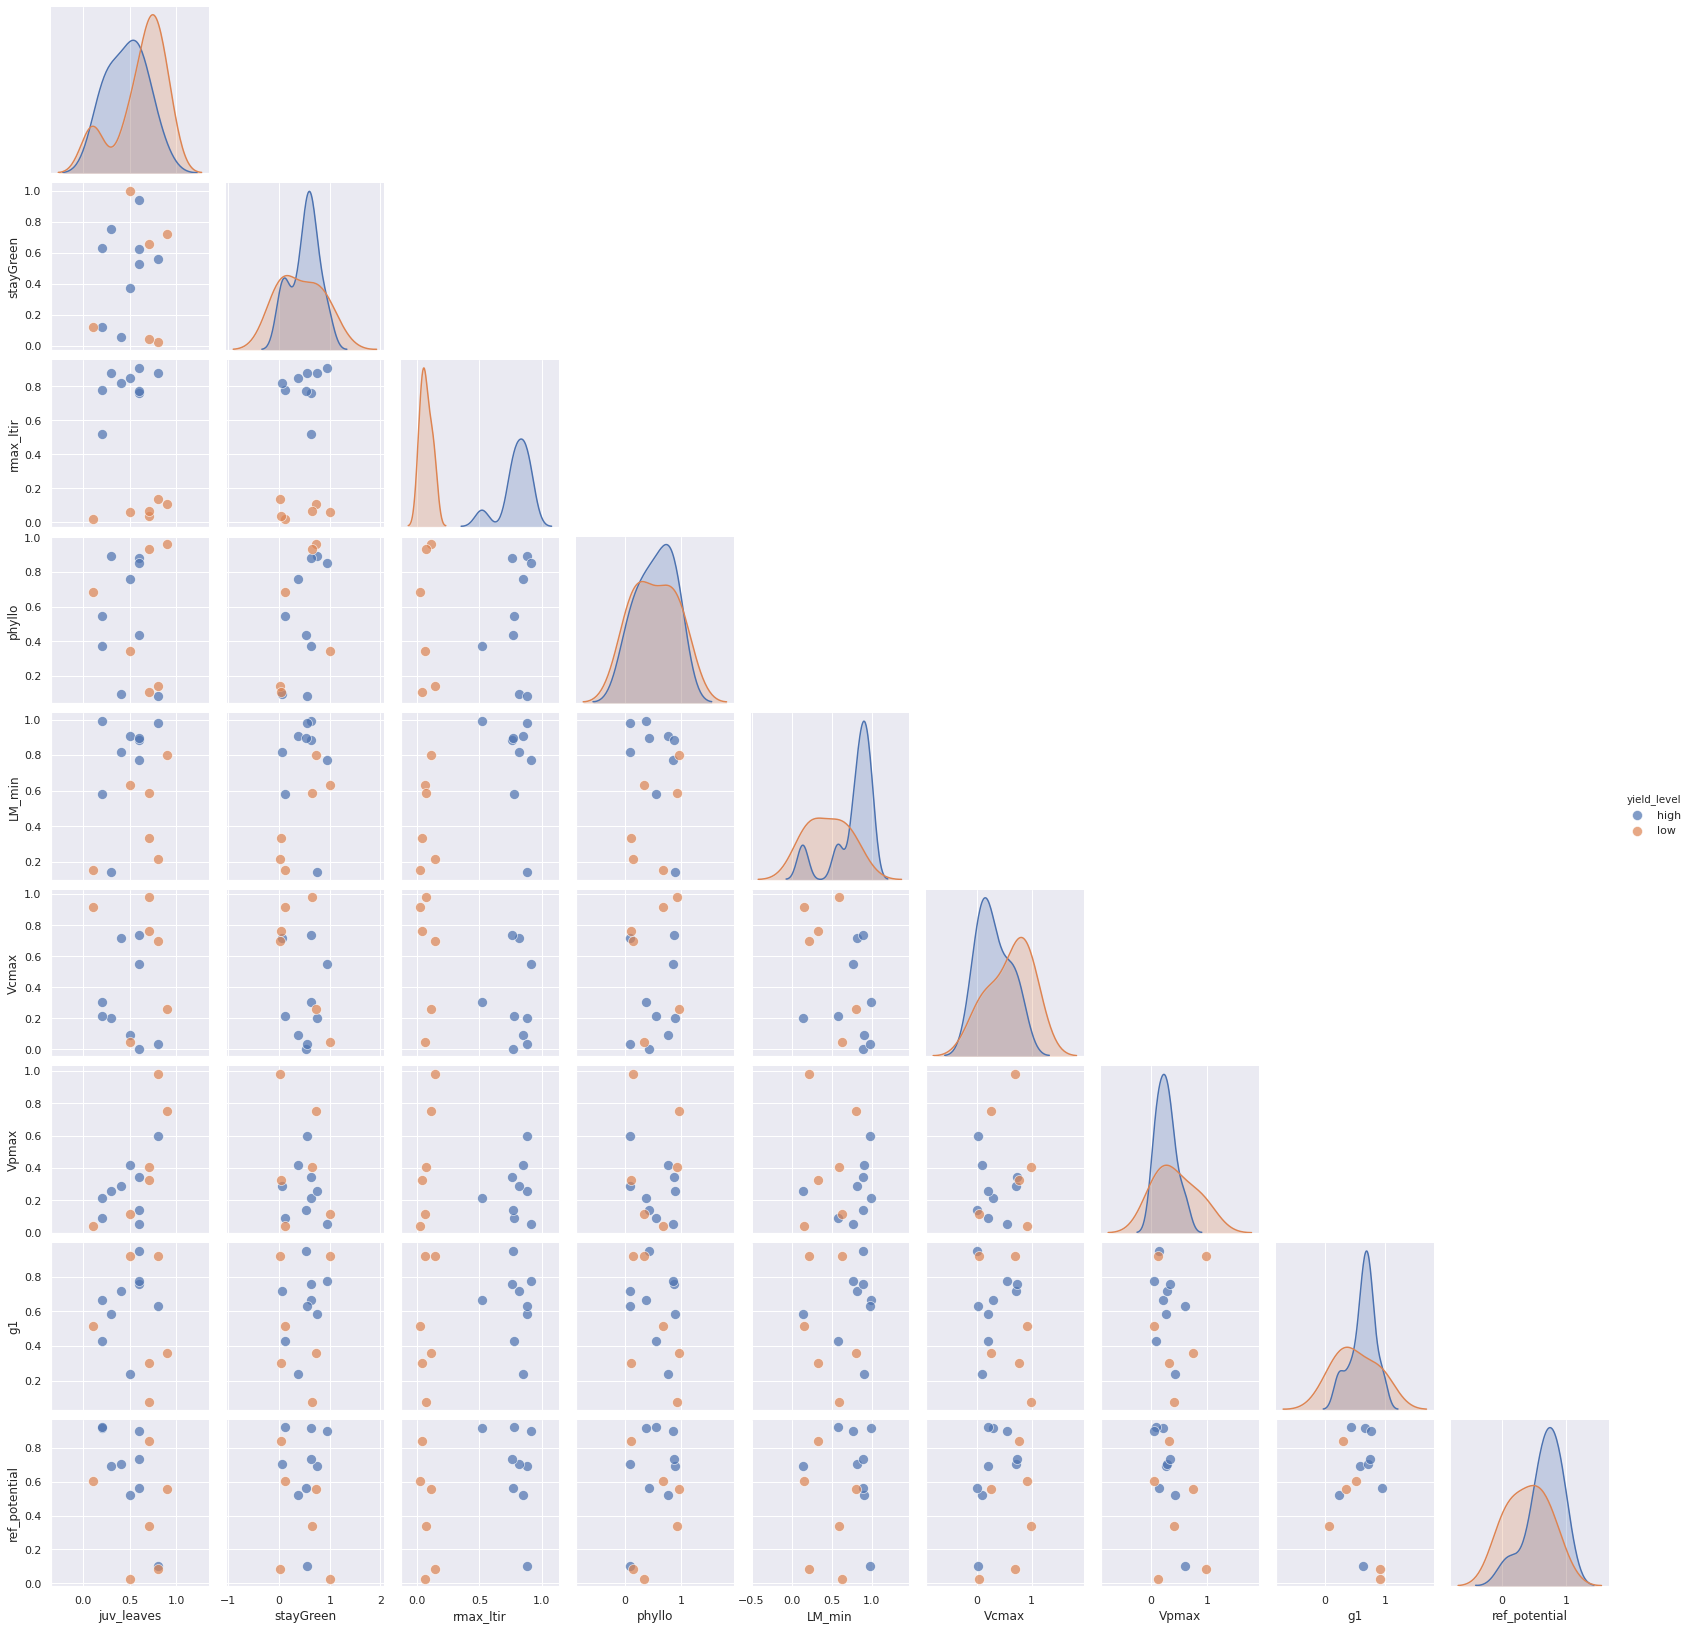

In [165]:
sns.set()
#df = sns.load_dataset("iris")
sns.pairplot(df_params_clean, hue='yield_level', corner=True,
             kind='scatter', plot_kws=dict(alpha=0.7, s=100))

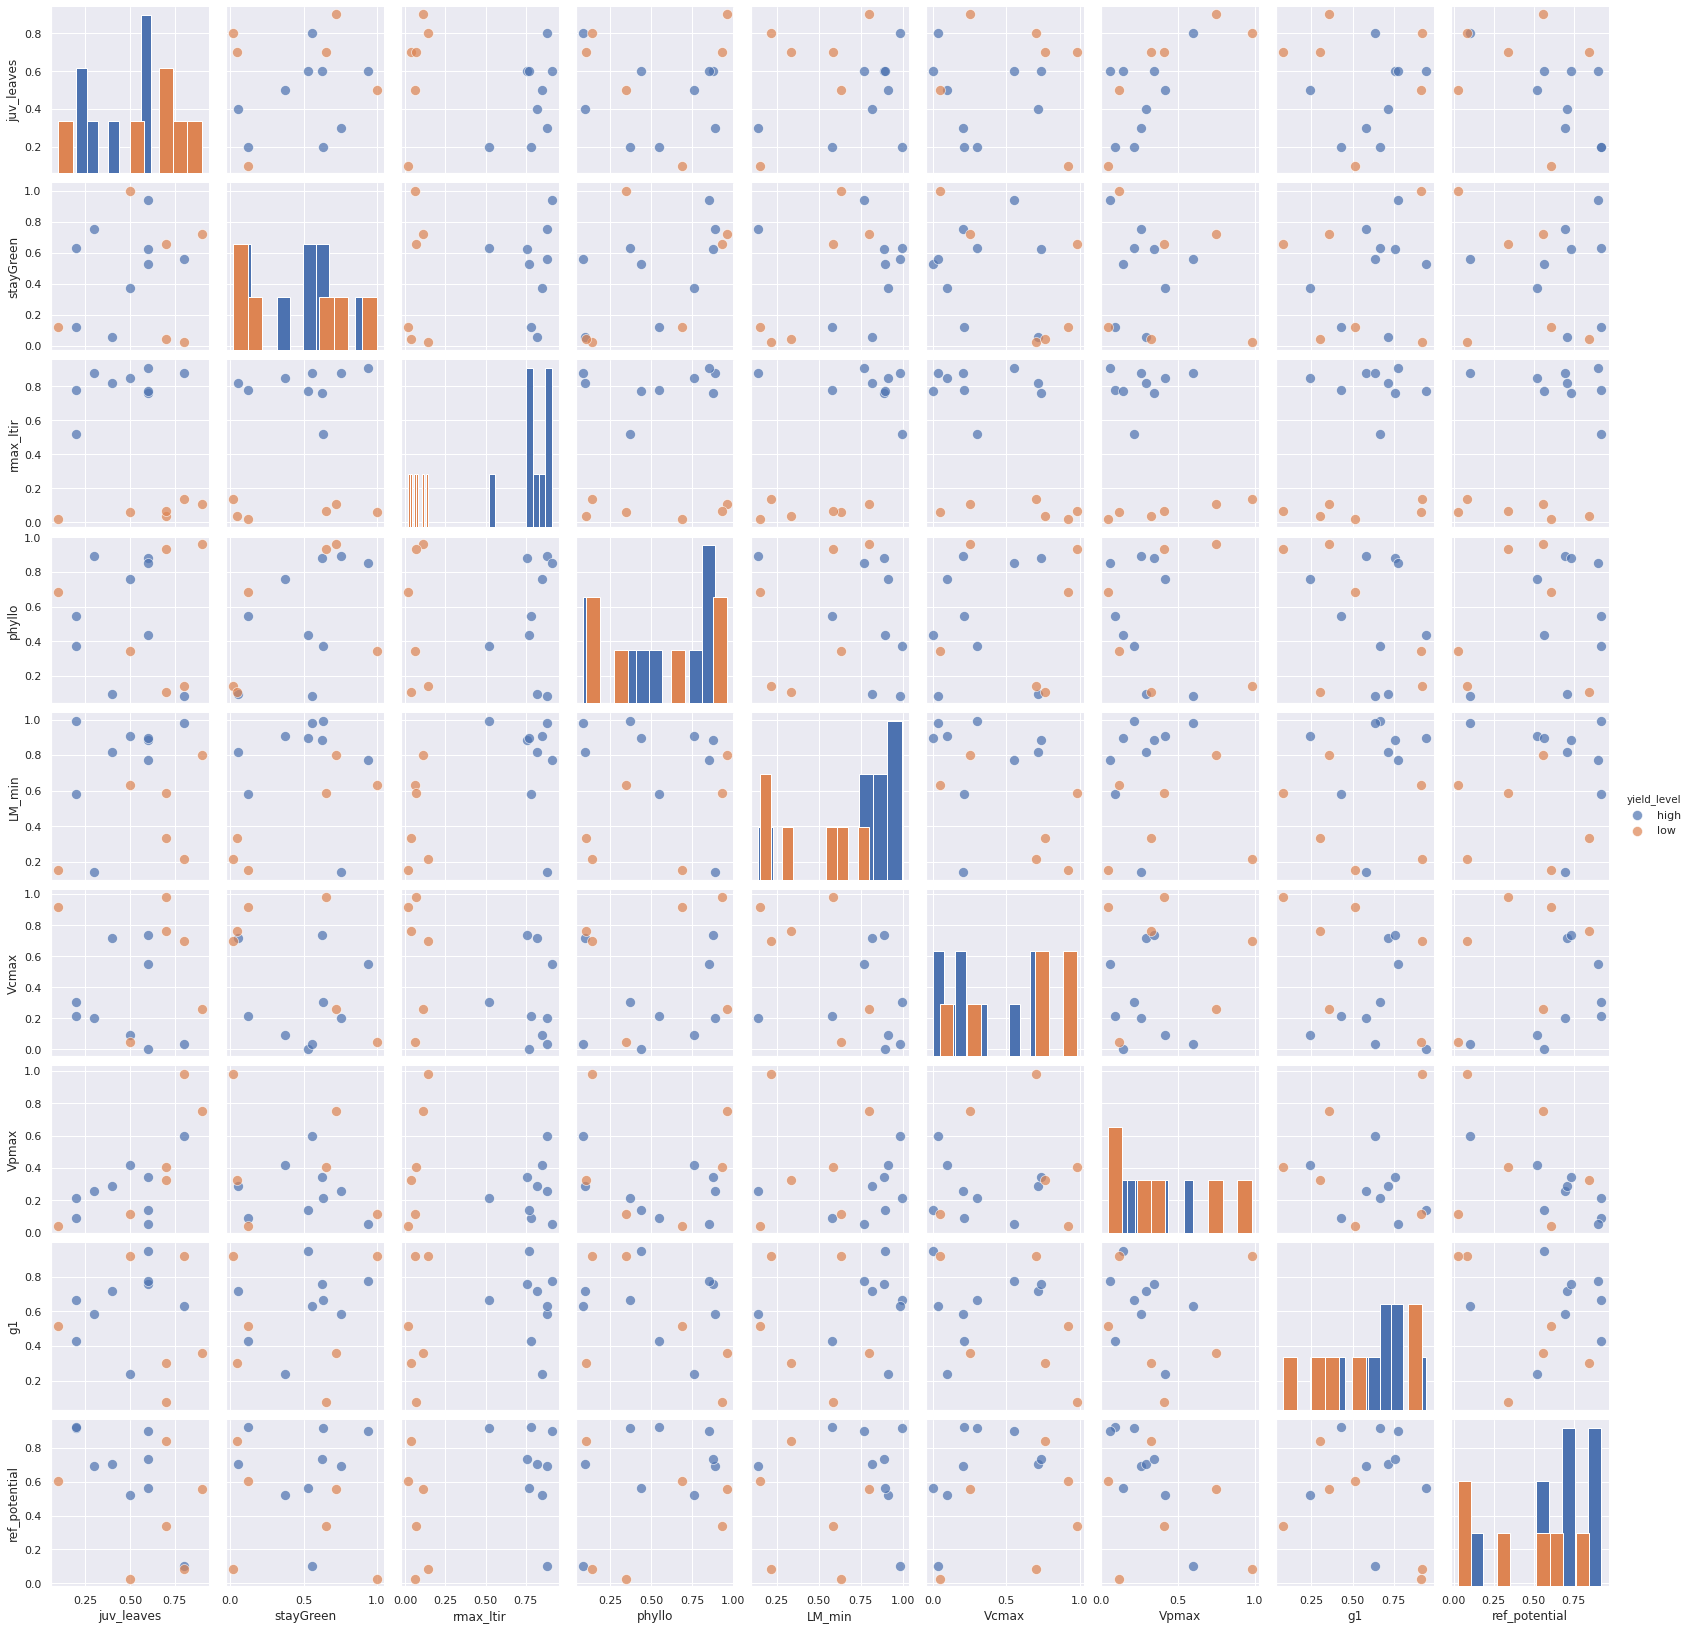

In [166]:
sns.set()
g = sns.pairplot(df_params_clean, hue='yield_level', diag_kind='hist',
                 plot_kws=dict(alpha=0.7, s=100))

In [ ]:
sns.set()
#df = sns.load_dataset("iris")
sns.pairplot(df_params_fold)

In [900]:
xpos = []
means_hyield = []
error_hyield = []
means_lyield = []
error_lyield = []

for counter,param in enumerate(params):
    xpos.append(counter)
    m = mean(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    e = stdev(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    n = len(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    means_hyield.append(m)
    error_hyield.append(e/np.sqrt(n))

for counter,param in enumerate(params):
    m = mean(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    e = stdev(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    n = len(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    means_lyield.append(m)
    error_lyield.append(e/np.sqrt(n))
    

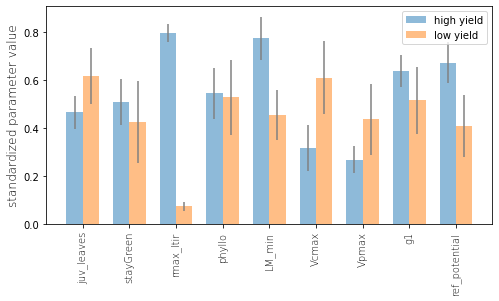

In [906]:
fig, ax = plt.subplots(figsize=(8,4))
w = 0.35
bars1 = ax.bar([x - w/2 for x in xpos], means_hyield, yerr=error_hyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='high yield')
bars2 = ax.bar([x + w/2 for x in xpos], means_lyield, yerr=error_lyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='low yield')
ax.set_xticks(xpos)
ax.set_xticklabels(params, rotation=90, weight='light')
ax.set_ylabel('standardized parameter value', size=12, weight='light')
ax.legend()